# Goal: 
## Predict the outcome of a game based on what heroes have been picked 

In [36]:
import helper_functions as hlf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [2]:
df = pd.read_csv('dota_games.txt', sep=",", header=None, names=["Sentinal_1", "Sentinal_2", 
                                                                "Sentinal_3", "Sentinal_4", "Sentinal_5",
                                                                "Scourge_1", "Scourge_2", "Scourge_3", 
                                                                "Scourge_4", "Scourge_5", "Won"])
df.head()

,Sentinal_1,Sentinal_2,Sentinal_3,Sentinal_4,Sentinal_5,Scourge_1,Scourge_2,Scourge_3,Scourge_4,Scourge_5,Won
0,Sven,Lone Druid,Venomancer,Clockwerk,Shadow Shaman,Invoker,Gyrocopter,Anti-Mage,Alchemist,Slark,2
1,Riki,Tinker,Puck,Leshrac,Nyx Assassin,Slardar,Sand King,Spectre,Necrolyte,Warlock,1
2,Invoker,Mirana,Pudge,Magnus,Keeper of the Light,Rubick,Tidehunter,Queen of Pain,Faceless Void,Sniper,2
3,Riki,Centaur Warrunner,Treant Protector,Queen of Pain,Broodmother,Rubick,Weaver,Troll Warlord,Alchemist,Drow Ranger,1
4,Razor,Kunkka,Drow Ranger,Leshrac,Zeus,Riki,Bane,Visage,Invoker,Timbersaw,1


In [3]:
# check for fragmented data
df.isnull().any()

Sentinal_1    False
Sentinal_2    False
Sentinal_3    False
Sentinal_4    False
Sentinal_5    False
Scourge_1     False
Scourge_2     False
Scourge_3     False
Scourge_4     False
Scourge_5     False
Won           False
dtype: bool

In [4]:
# create a new df with all the winning teams lineups
sentinal_df = df[['Sentinal_1','Sentinal_2','Sentinal_3','Sentinal_4','Sentinal_5','Won']]
sentinal_winners = sentinal_df[df.Won == 1]
sentinal_winners.rename(columns={'Sentinal_1': "Hero_1", 'Sentinal_2': "Hero_2", 
                               'Sentinal_3': "Hero_3", 'Sentinal_4': "Hero_4",
                               'Sentinal_5': "Hero_5"}, inplace=True)

scourge_df = df[['Scourge_1','Scourge_2','Scourge_3','Scourge_4','Scourge_5','Won']]
scourge_winners = scourge_df[df.Won == 2]
scourge_winners['Won'] = 1
scourge_winners.rename(columns={'Scourge_1': "Hero_1", 'Scourge_2': "Hero_2", 
                               'Scourge_3': "Hero_3", 'Scourge_4': "Hero_4",
                               'Scourge_5': "Hero_5"}, inplace=True)

# create a new df for the losing teams

sentinal_losers = sentinal_df[df.Won == 2]
sentinal_losers['Won'] = 0
sentinal_losers.rename(columns={'Sentinal_1': "Hero_1", 'Sentinal_2': "Hero_2", 
                               'Sentinal_3': "Hero_3", 'Sentinal_4': "Hero_4",
                               'Sentinal_5': "Hero_5"}, inplace=True)

scourge_losers = scourge_df[df.Won == 1]
scourge_losers['Won'] = 0
scourge_losers.rename(columns={'Scourge_1': "Hero_1", 'Scourge_2': "Hero_2", 
                               'Scourge_3': "Hero_3", 'Scourge_4': "Hero_4",
                               'Scourge_5': "Hero_5"}, inplace=True)

# merge the dataframes to create a df that contains all the lineups and if they won or not
lineups = pd.concat([sentinal_winners, scourge_winners, sentinal_losers, scourge_losers])
lineups.reset_index(drop=True, inplace=True)
lineups.head()
lines_csv = lineups.to_csv('lineups.csv', index = None, header=True)

D:\Programs\Anaconda\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

In [5]:
# split the hero list from the outcome of the game
features_df = lineups.drop('Won', axis=1)

# use the populate function to create dummies columns for all the characters in the game
dummies_df = hlf.populate_df(features_df)
no_features_df = pd.concat([dummies_df, lineups.Won], axis=1)
# dummies_csv = no_features_df.to_csv ('dota2_dummies.csv')

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future be

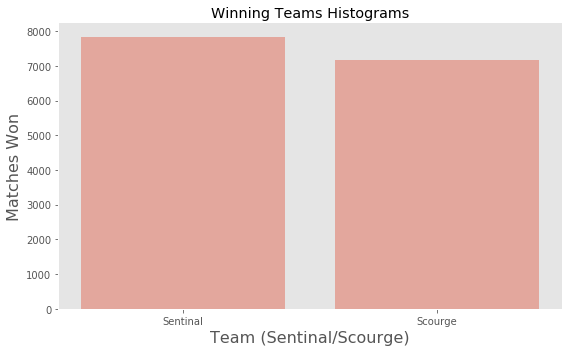

In [37]:
# check for class imbalance
outcome_df = pd.get_dummies(lineups.Won)
outcome_df = outcome_df.rename(columns={0:'Sentinal', 1: 'Scourge'})
sum_wins_by_team = pd.concat([dummies_df, outcome_df], axis=1)

sum_wins_by_team = sum_wins_by_team.groupby(['Sentinal', 'Scourge']).sum()
sum_wins_by_team.reset_index(inplace=True)

sum_wins_by_team['Sentinal'][1] = len(sentinal_winners)
sum_wins_by_team['Sentinal'][0] = (15000 - len(sentinal_winners))
sum_wins_by_team.drop('Scourge', axis=1, inplace=True)

# Plot the bar chat to show how many times each team won 
plt.figure(figsize=(8, 5)) 
plt.bar(['Sentinal', 'Scourge'], [len(sentinal_winners), (15000-len(sentinal_winners))], alpha=0.4)

# Remove the plot frame lines. 
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
plt.grid(b=None)

# set labels
plt.title("Winning Teams Histograms")
plt.xlabel("Team (Sentinal/Scourge)", fontsize=16)  
plt.ylabel("Matches Won", fontsize=16)
plt.savefig('classes_hist.png')

In [7]:
# Sort characters based on their main attribute (Strength, Agility, Intellegence)
str_heroes = hlf.character_by_attributes('Strength')
agi_heroes = hlf.character_by_attributes('Agility')
int_heroes = hlf.character_by_attributes('Intelligence')

# removing some extra special characters
agi_heroes = [x.replace('_', ' ') for x in agi_heroes]
int_heroes = [x.replace('_', ' ') for x in int_heroes]
int_heroes = [x.replace('%27', "'") for x in int_heroes]

In [9]:
# create a new feature: how many strength heroes
str_df = features_df.where(~features_df.isin(str_heroes), None)
str_df = pd.DataFrame(str_df.isnull().sum(axis=1), columns=['Strength'])
# str_df.head()

In [10]:
# create a new feature: how many agility heroes
agi_df = features_df.where(~features_df.isin(agi_heroes), None)
agi_df = pd.DataFrame(agi_df.isnull().sum(axis=1), columns=['Agility'])
# agi_df.head()

In [11]:
# create a new feature: how many inteligence heroes
int_df = features_df.where(~features_df.isin(int_heroes), None)
int_df = pd.DataFrame(int_df.isnull().sum(axis=1), columns=['Intelligence'])
# int_df.head()

In [12]:
# ranged heroes
ranged = np.array(['Techies', 'Ancient Apparition', 'Lina', 'Chen', 'Enchantress', 
                   'Mirana', 'Pugna', 'Arc Warden', 'Disruptor', 'Drow Ranger', 
                   'Skywrath Mage', 'Oracle', 'Crystal Maiden', 'Death Prophet', 'Invoker', 
                   'Keeper of the Light', 'Leshrac', 'Lion', 'Medusa', "Nature's Prophet", 
                   'Silencer', 'Visage', 'Warlock', 'Windrunner', 'Witch Doctor',  'Clinkz', 
                   'Viper', 'Dazzle', 'Lich', 'Lone Druid', 'Puck', 'Queen of Pain', 'Rubick', 
                   'Sniper', 'Enigma', 'Wisp', 'Necrophos', 'Phoenix', 'Shadow Demon', 
                   'Shadow Fiend', 'Tinker', 'Troll Warlord', 'Storm Spirit', 'Razor', 
                   'Outworld Devourer', 'Venomancer', 'Weaver', 'Winter Wyvern', 'Bane', 
                   'Huskar', 'Jakiro', 'Shadow Shaman', 'Vengeful Spirit', 'Zeus', 'Batrider', 
                   'Gyrocopter', 'Morphling', 'Luna'])

# create a new feature: how many melee heroes in the team
melee_df = features_df.where(~features_df.isin(ranged), None)
melee_df = pd.DataFrame(melee_df.isnull().sum(axis=1), columns=['Ranged'])
# melee_df.tail()

In [13]:
# tier lists
tier1 = np.array(['Alchemist', 'Enchan', 'Lifestealer', 'Visage',
                 'Wisp', 'Outerworld Devourer', 'Weaver',
                 "Nature's Prophet", 'Rubick'])

tier2 = np.array(['Nyx Assassin', 'Gyrocopter', 
                  'Alchemist', 'Puck', 'Chen'])

tier3 = np.array(['Shadow Demon', 'Lone Druid', 'Clockwerk', 'Queen of Pain',
                  'Dragon Knight', 'Treant Protector', 'Keeper of the Light'
                  'Bane', 'Jakiro', 'Anti-Mage', 'Timbersaw', 'Storm Spirit',
                  'Razor', 'Enchantress', 'Bounty Hunter', 'Templar Assassin',
                  'Abaddon', 'Crystal Maiden', 'Windrunner', 'Magnus', 
                  'Shadow Fiend', 'Leshrac'])

# create a new feature: how many characters are tier 1,2 or 3
op_tiers12_df = features_df.where(~features_df.isin(tier1) & ~features_df.isin(tier2), None)
op_tiers12_df = pd.DataFrame(op_tiers12_df.isnull().sum(axis=1), columns=['Tiers_12'])
# op_tiers12_df.head()

op_tiers3_df = features_df.where(~features_df.isin(tier3), None)
op_tiers3_df = pd.DataFrame(op_tiers3_df.isnull().sum(axis=1), columns=['Tier_3'])
# op_tiers3_df.head()

In [14]:
# Safe lane Carry characters
carry = np.array(['Alchemist', 'Anti-Mage', 'Arc Warden', 'Bloodseeker', 'Clinkz'
                  'Chaos Knight', 'Drow Ranger', 'Faceless Void', 'Gyrocopter',
                  'Huskar', 'Juggernaut', 'Kunkka', 'Lifestealer', 'Lone Druid',
                  'Luna', 'Lycan' 'Medusa', 'Meepo', 'Morphling', 'Naga Siren',
                  'Phantom Assassin', 'Phantom Lancer', 'Slark', 'Spectre',
                  'Sven', 'Terrorblade', 'Timbersaw', 'Troll Warlord', 'Tiny',
                  'Ursa', 'Vengeful Spirit', 'Venomancer', 'Viper', 'Weaver'])

# create new feature: amount of carry character in a team
carry_df = features_df.where(~features_df.isin(carry), None)
carry_df = pd.DataFrame(carry_df.isnull().sum(axis=1), columns=['Carry']) 
# carry_df.head()

In [15]:
# support characters
support = np.array(['Ancient Apparition', 'Bristleback', 'Clockwerk', 'Chen',
                    'Bane', 'Crystal Maiden', 'Dazzle', 'Disruptor', 'Doom',
                    'Earthshaker', 'Enchantress', 'Wisp', 'Jakiro', 'Leshrac'
                    'Keeper of the Light', 'Lich', 'Lina', 'Lion', 'Nyx Assassin',
                    'Ogre Magi', 'Omniknight', 'Oracle', 'Phoenix', 'Rubick',
                    'Shadow Demon', 'Shadow Shaman', 'Silencer', 'Treant Protector',
                    'Undying', 'Visage', 'Warlock', 'Weaver', 'Windrunner', 'Winter Wyvern',
                    'Witch Doctor', 'Oracle'])

# create new feature: amount of support characters in a team
support_df = features_df.where(~features_df.isin(support), None)
support_df = pd.DataFrame(support_df.isnull().sum(axis=1), columns=['Support']) 
# support_df.head()

In [16]:
#offlane characters
offlane = np.array(['Abaddon', 'Axe', 'Batrider', 'Beasmaster',
                    'Brewmaster', 'Bristleback', 'Broodmother',
                    'Centaur Warrunner', 'Clockwerk', 'Dark Seer',
                    'Doom', 'Earthshaker', 'Enchantress', 'Enigma',
                    'Legion Commander', 'Magnus', "Nature's Prophet",
                    'Night Stalker', 'Nyx Assassin', 'Puck',
                    'Sand King', 'Slardar', 'Spirit Breaker', 
                    'Tidehunter', 'Undying', 'Underlord'])

# create new feature: amount of offlane characters in a team
offlane_df = features_df.where(~features_df.isin(offlane), None)
offlane_df = pd.DataFrame(offlane_df.isnull().sum(axis=1), columns=['Offlane'])
# offlane_df.head()

In [17]:
# middle lane characters
mid = np.array(['Alchemist', 'Arc Warden', 'Bloodseeker', 'Bristleback',
                'Broodmother', 'Death Prophet', 'Dragon Knight', 'Ember Spirit',
                'Faceless Void', 'Invoker', 'Wisp', 'Juggernaut',
                'Lina', 'Leshrac', 'Lone Druid', 'Magnus', 'Medusa', 'Meepo',
                'Mirana', "Nature's Prophet", 'Necrophos', 'Outworld Devourer',
                'Puck', 'Pugna', 'Queen of Pain', 'Razor', 'Shadow Fiend','Zeus' 
                'Skywrath Mage', 'Sniper', 'Storm Spirit', 'Templar Assassin',
                'Tinker', 'Tiny', 'Venomancer', 'Viper', 'Visage', 'Windrunner'])

# create new feature: how many mid lane appropriate characters
mid_df = features_df.where(~features_df.isin(mid), None)
mid_df = pd.DataFrame(mid_df.isnull().sum(axis=1), columns=['Mid'])
# mid_df.head()

In [18]:
# roaming support characters
roaming_support = np.array(['Bounty Hunter', 'Earth Spirit', 'Mirana', "Nature's Prophet",
                            'Pudge', 'Riki', 'Tusk', 'Techies', 'Spirit Breaker', 'Bane'
                            'Night Stalker', 'Windrunner', 'Lion', 'Earthshaker', 'Rubick'])

# create new feature: how many roaming characters
roam_df = features_df.where(~features_df.isin(roaming_support), None)
roam_df = pd.DataFrame(roam_df.isnull().sum(axis=1), columns=['Roamer'])
# roam_df.head()

In [19]:
# nuke/disable characters
nuke_disable = np.array(['Crystal Maiden', 'Lina', 'Lion', 'Oracle', 'Skywrath Mage', 'Witch Doctor',
                         'Earthshaker', 'Death Prophet', 'Lich', 'Ancient Apparition', 'Shadow Shaman',
                         'Puck', 'Jakiro', 'Necrophos', 'Leshrac', 'Disruptor', 'Outworld Devourer',
                         'Bane', 'Ogre Magi', 'Zeus', 'Doom', 'Dazzle', 'Morphling', 'Nyx Assassin',
                         'Rubick', 'Queen of Pain', 'Tinker'])

# create new feature: how many nukers/disablers in team
nuke_disable_df = features_df.where(~features_df.isin(nuke_disable), None)
nuke_disable_df = pd.DataFrame(nuke_disable_df.isnull().sum(axis=1), columns=['Nuke/Disable'])
# nuke_disable_df.head()

<Figure size 864x576 with 0 Axes>

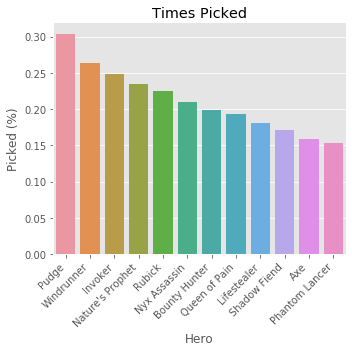

In [45]:
# see the list of most played hereos 
sum_picked = pd.DataFrame(dummies_df.sum(), columns=["Picked"])
sum_picked.sort_values(by=['Picked'], ascending=False, inplace=True)

sum_picked = sum_picked[['Picked']].apply(lambda x: x / 15000)
sum_picked.reset_index(inplace=True)
sum_picked.rename(columns={'index':'Hero'}, inplace=True)

top12_picked = sum_picked.head(12)

# plot the top winners
plt.figure(figsize=(12,8))
sns.catplot(kind='bar', data=top12_picked, x='Hero', y='Picked')
plt.title('Times Picked')
plt.ylabel('Picked (%)')
plt.xticks(rotation=45, ha='right')
plt.savefig('most_picked.png')

<Figure size 864x576 with 0 Axes>

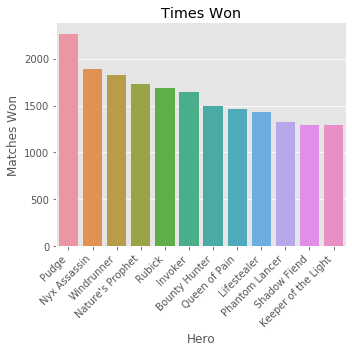

In [46]:
# see which hereos won the most games
winners_df = no_features_df.loc[no_features_df.Won == 1]
winners_df.drop('Won', axis=1, inplace=True)
sum_wins = pd.DataFrame(winners_df.sum(), columns=["Win"])

sort_sum_wins = sum_wins.sort_values(by=['Win'], ascending=False)
sort_sum_wins = sort_sum_wins[['Win']]
sort_sum_wins.reset_index(inplace=True)
sort_sum_wins.rename(columns={'index':'Hero'}, inplace=True)

top12_wins = sort_sum_wins.head(12)

# plot the top winners
plt.figure(figsize=(12,8))
sns.catplot(kind='bar', data=top12_wins, x='Hero', y='Win')
plt.title('Times Won')
plt.ylabel('Matches Won')
plt.xticks(rotation=45, ha='right')
plt.savefig('most_won.png')

<Figure size 864x576 with 0 Axes>

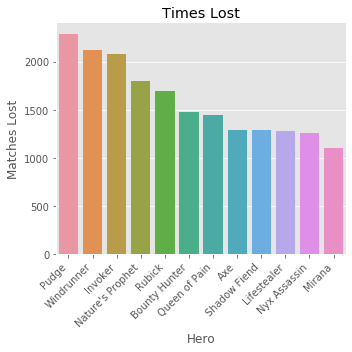

In [47]:
# see which heroes lost the least
losers_df = no_features_df.loc[no_features_df.Won == 0]
losers_df.drop('Won', axis=1, inplace=True)
sum_lose = pd.DataFrame(losers_df.sum(), columns=["Lose"])

sort_sum_lose = sum_lose.sort_values(by=['Lose'], ascending=False)

sort_sum_lose = sort_sum_lose[['Lose']]
sort_sum_lose.reset_index(inplace=True)
sort_sum_lose.rename(columns={'index':'Hero'}, inplace=True)

top12_lose = sort_sum_lose.head(12)

# plot the top winners
plt.figure(figsize=(12,8))
sns.catplot(kind='bar', data=top12_lose, x='Hero', y='Lose')
plt.title('Times Lost')
plt.ylabel('Matches Lost')
plt.xticks(rotation=45, ha='right')
plt.savefig('most_lost.png')                 

<Figure size 864x576 with 0 Axes>

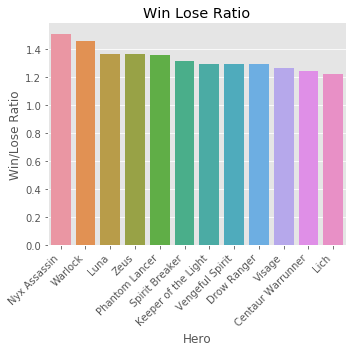

In [48]:
win_lose_df = pd.concat([sum_wins, sum_lose], axis=1).reset_index().rename(columns={'index':'Hero'})
win_lose_df['Ratio'] = win_lose_df['Win'] / win_lose_df['Lose']

# sort the characters by win/lose ratio
win_lose_df.sort_values(by=['Ratio'], ascending=False, inplace=True)
sort_ratio = win_lose_df[['Hero','Ratio']]

# extract the characters with highest/lowest win to lose ratio
top12_ratio = sort_ratio.head(12)
bot12_ratio = sort_ratio.tail(12)

# plot the highest win to lose ratio
plt.figure(figsize=(12,8))
sns.catplot(kind='bar', data=top12_ratio, x='Hero', y='Ratio')

# add labels
plt.title('Win Lose Ratio')
plt.ylabel('Win/Lose Ratio')
plt.xticks(rotation=45, ha='right')
plt.savefig('win_lose_ratio.png')                

In [66]:
# add features: 
top12_heroes = np.array(top12_ratio['Hero'])
bot12_heroes = np.array(bot12_ratio['Hero'])

# create new feature: heroes with highest win rate
high_rate_df = features_df.where(~features_df.isin(top12_heroes), None)
high_rate_df = pd.DataFrame(high_rate_df.isnull().sum(axis=1), columns=['High_Win'])

# create new feature: heroes with lowest win rate
low_rate_df = features_df.where(~features_df.isin(bot12_heroes), None)
low_rate_df = pd.DataFrame(low_rate_df.isnull().sum(axis=1), columns=['Low_Win'])

In [24]:
# 2018 most used characters - patch 7.19
picked_719 = np.array(['Mirana', 'Earthshaker', 'Tiny', 'Necrophos', 'Weaver',
                        'Winter Wyvern', 'Phoenix', 'Lina', 'Bane', 'Phantom Lancer'])

# create new feature: heroes with the most wins during patch 7.19
picked_719_df = features_df.where(~features_df.isin(picked_719), None)
picked_719_df = pd.DataFrame(picked_719_df.isnull().sum(axis=1), columns=['Most_Picked_719'])
# picked_719_df.head()

In [25]:
# 2018 most used characters - patch 7.20
picked_720 = np.array(['Rubick', 'Lich', 'Phantom Assassin', 'Brewmaster', 'Centaur Warrunner',
                        'Dazzle', 'Sand King', 'Tusk', 'Terrorblade'])

# create new feature: heroes with the most wins during patch 7.20
picked_720_df = features_df.where(~features_df.isin(picked_720), None)
picked_720_df = pd.DataFrame(picked_720_df.isnull().sum(axis=1), columns=['Most_Picked_720'])
# picked_720_df.head()

In [26]:
# concatanate all the features together
cleaned_df = pd.concat([dummies_df, melee_df, str_df, agi_df, int_df, 
                         op_tiers12_df, op_tiers3_df, carry_df, support_df, 
                         offlane_df, mid_df, roam_df, nuke_disable_df,
                         high_rate_df, low_rate_df, picked_719_df, 
                         picked_720_df], axis=1)
                         
                         

# scaling featires
cols = cleaned_df.columns
scaler = StandardScaler()
scaler.fit(cleaned_df)
scaled_features = scaler.transform(cleaned_df)

# combine the labels with the scaled features
scaled_features_df = pd.DataFrame(scaled_features, columns=cols, index=cleaned_df.index)
scaled_features_df = pd.concat([scaled_features_df, lineups['Won']], axis=1)

# save as new csv to for modeling purpose
scaled_csv = scaled_features_df.to_csv('dota2_scaled.csv', index=None, header=True)
scaled_features_df

,Riki,Razor,Morphling,Brewmaster,Slardar,Wisp,Omniknight,Slark,Ogre Magi,Chaos Knight,...,Tier_3,Carry,Support,Offlane,Mid,Roamer,Nuke/Disable,Most_Picked_719,Most_Picked_720,Won
0,5.253443,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-0.113087,-1.615486,-0.493732,1.007526,1.261730,0.157217,3.185349,-0.678438,-0.650247,1
1,5.253443,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,0.995611,-1.615486,-0.493732,1.007526,0.266544,0.157217,-0.254635,-0.678438,1.141562,1
2,-0.190351,6.441500,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,0.995611,0.711521,-1.621490,-1.304373,0.266544,-1.058379,0.892026,-0.678438,-0.650247,1
3,-0.190351,6.441500,5.349299,-0.181034,-0.187513,-0.21094,5.444586,-0.245093,-0.197112,-0.211026,...,0.995611,-0.451982,0.634025,-1.304373,-0.728642,0.157217,0.892026,-0.678438,-0.650247,1
4,5.253443,-0.155243,-0.186940,5.523822,-0.187513,-0.21094,-0.183669,-0.245093,5.073260,-0.211026,...,-0.113087,-0.451982,-0.493732,-0.148424,-0.728642,0.157217,0.892026,-0.678438,1.141562,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-0.190351,-0.155243,5.349299,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-0.113087,0.711521,-0.493732,-0.148424,-0.728642,1.372813,-0.254635,-0.678438,-0.650247,0
29996,-0.190351,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-0.113087,-0.451982,-0.493732,-0.148424,0.266544,2.588409,-0.254635,2.694918,-0.650247,0
29997,-0.190351,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-0.113087,-0.451982,1.761783,-1.304373,0.266544,-1.058379,0.892026,-0.678438,-0.650247,0
29998,-0.190351,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-0.113087,-0.451982,0.634025,1.007526,-0.728642,0.157217,0.892026,-0.678438,-0.650247,0


In [33]:
feature_names = cleaned_df.columns.values

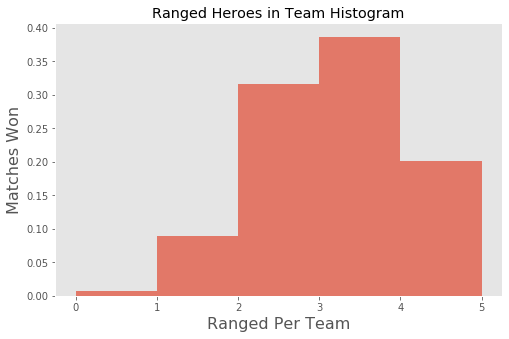

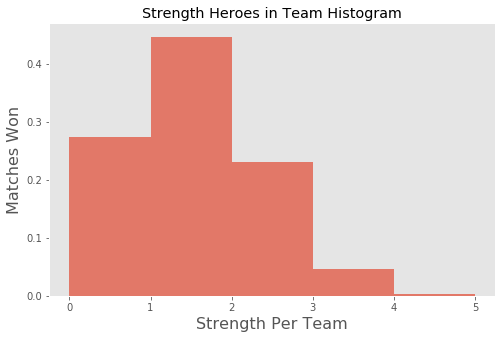

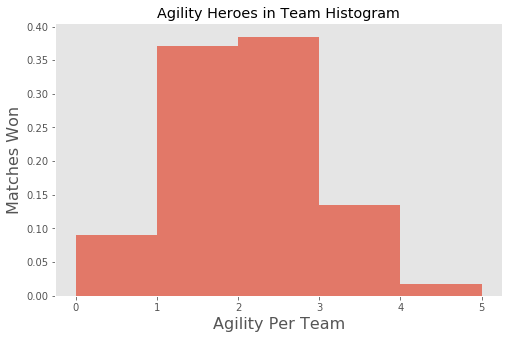

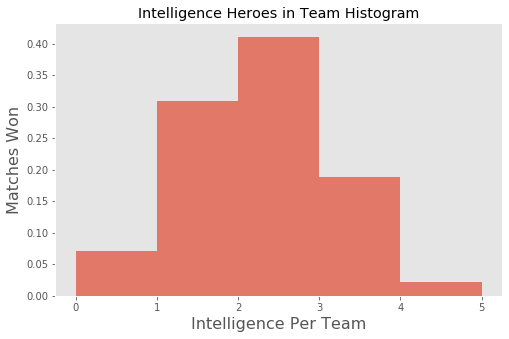

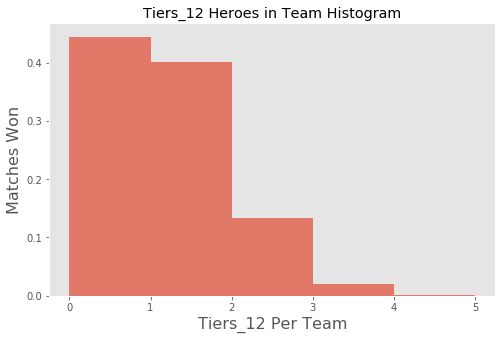

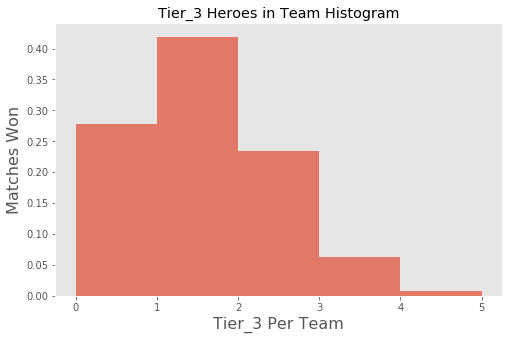

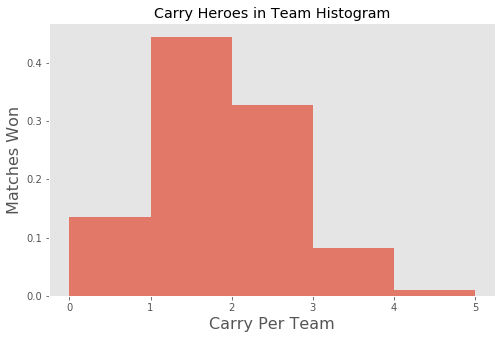

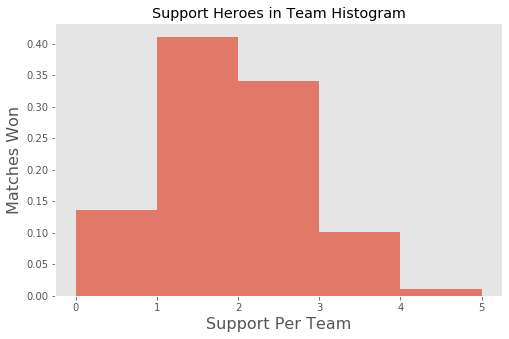

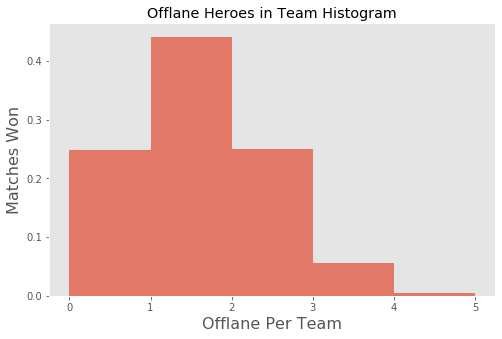

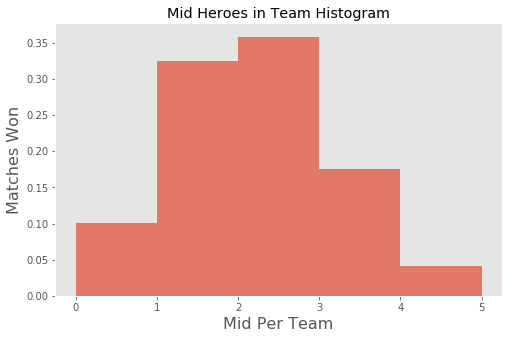

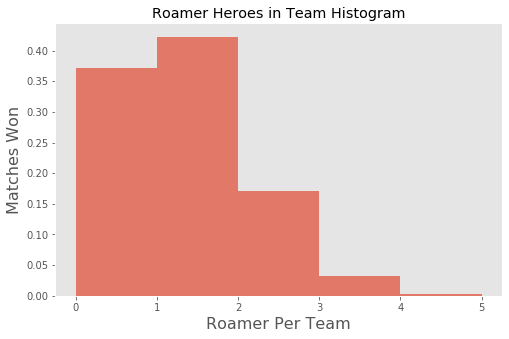

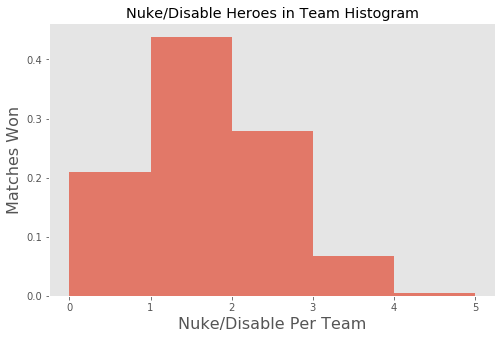

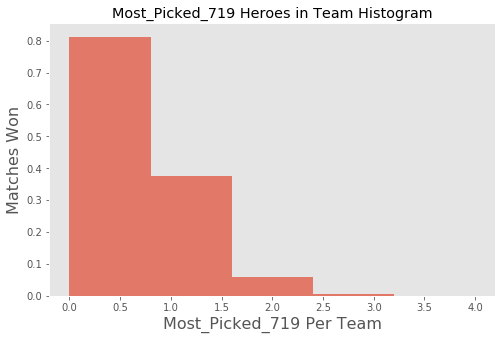

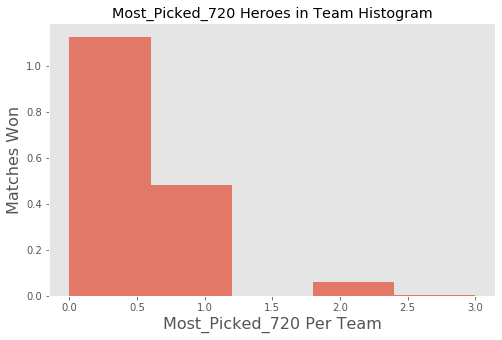

In [35]:
for feature in feature_names:
    if feature not in dummies_df and feature != 'Won':
        hlf.create_hist(cleaned_df, feature)